In [ ]:
### GGS 416 - Final Individual Project - Deforestation Analysis ###
# Rachael Nicoletta 
# Due 11/29/2022

In [28]:
### Useful Imports and Globals ###
import os

# Sentinel API specific. Imports sys and installs Sentinel API package in current virtual environment
import sys
!{sys.executable} -m pip install sentinelsat

# For creating gifs with the images
!{sys.executable} -m pip install imageio
import imageio

# Imports classes to connect to Copernicus Open Access Hub (sentinelsat) and
# other relevant geojson packages.
import sentinelsat
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date

# Working with data
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd

# For unzipping zipped packages
import zipfile

# For traversing directories and getting file names and paths
import shutil
import glob

# Plotting
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

# Several of our functions change our current working directory but lots of other functions require the file
# path to our base directory. This creates a variable of the home directory from the start for future use.
home_directory = os.getcwd()
#print(home_directory)

     ---------------------------------------- 3.4/3.4 MB 10.7 MB/s eta 0:00:00


In [43]:
### Rachael (but most of it adapted from lecture notes) - Downloading Sentinel-2 Imagery ###

# Creates an object containing our Sentinel API key data linked with my account.
api = SentinelAPI(
    'rnicole', 
    'Ranvegan_0421',
    'https://apihub.copernicus.eu/apihub'
)

# Defining the GeoJSON type as a single geometry, a polygon, and its boundaries. This is a patch 
# of area in Brazil experiencing forest loss within the past few months according to the 
# Global Forest Watch website: https://www.globalforestwatch.org/
footprint = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "coordinates": [
          [
            [
              -56.740268336722835,
              -12.968248585734003
            ],
            [
              -56.740268336722835,
              -12.975218352793988
            ],
            [
              -56.732551395688105,
              -12.975218352793988
            ],
            [
              -56.732551395688105,
              -12.968248585734003
            ],
            [
              -56.740268336722835,
              -12.968248585734003
            ]
          ]
        ],
        "type": "Polygon"
  }
}
footprint = geojson_to_wkt(footprint)

# Sends an api request to the sentinel server to search for images intersecting
# our polygon boundaries and within our specified timeframe and platform (Sentinel-2).
image_metadata = api.query(
    footprint,
    date=('20220801', '20221125'), # August to November 2022 (recent data)
    platformname = 'Sentinel-2',
    processinglevel = 'Level-2A', 
    cloudcoverpercentage = ('0', '50') # Only pulls data with less than 50% cloud coverage
)

image_metadata_df = api.to_dataframe(image_metadata)
#print(image_metadata_df)

# Sorts the metadata by cloud coverage (lowest up top)
image_metadata_df_sorted = image_metadata_df.sort_values(['cloudcoverpercentage'], ascending=[True])

# Exports to a csv file
image_metadata_df.to_csv("image_data4.csv")

# Downloads all images from dataframe. 
# ** Keep commented unless you need to download the images again. **
# api.download_all(image_metadata_df_sorted.index)

In [10]:
### Unzipping folders (from lecture notes) ###

def unzip_files():
    # Get a list of all filenames in our directory
    all_filenames_in_folder = os.listdir() 

    # Create an empty list for the filenames we want to unzip
    filenames_to_unzip = []

    # Loop over filenames and put .zip files in our list
    for filename in all_filenames_in_folder:
        if filename.endswith('.zip'): # Only let .zip files append 
            filenames_to_unzip.append(filename)

    # Creates a new folder for our unzipped files
    folder = 'unzipped'
    if not os.path.exists(folder):
        os.mkdir(folder) # Make the folder if it does not exist 

    for filename in filenames_to_unzip:
        # Unzip the zip file and put it in the 'unzipped' folder
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(folder)

        os.remove(filename)
        
unzip_files()

In [11]:
### Rachael - Pull the bands we want from data download ###

# Collection of the band types we want to grab (all extensions are specifically for Level-1C files)
# Red (B04), NIR (B08) 
extensions = ['B08_10m.jp2', 'B04_10m.jp2', 'TCI_10m.jp2']

# Recursively navigates 'unzipped' folder for all images with our chosen bands.
# Appends path name of each file found into a list
def findExt(folder):
    matches = []
    for root, dirnames, filenames in os.walk(folder):
        for ext in extensions:
            for filename in filenames:
                if filename.endswith(ext):
                    matches.append(os.path.join(root, filename))
    return matches

# List of filenames and their paths to move
files_to_move = findExt("unzipped")

# Directory to compile all of the files we find into
dest_dir = "files_collection"

# Copies every file from our list into our 'files_collection' folder
for file in files_to_move:
    shutil.copy(file,dest_dir)
    
# IMPORTANT CONSIDERATION: the files are copied in bulk and need to be manually sorted into separate 
# RGB and NIR folders for future functions to work.

In [42]:
### Clipping Files ###

def clip_raster(mask_bounds):
    
    # Gets the filename of each file in the files_collection folder to be clipped
    files = os.listdir('files_collection')

    # Get mix and max x, y bounds from tuple
    xmin, ymin, xmax, ymax = mask_bounds
    
    # Iterates through each file and clips to the given bounds
    for file in files:
        
        path = 'files_collection/' + file
    
        # Define a rasterio object so we can use rasterio functions
        raster_image = rasterio.open(path)

        # Defines the geometry type of our AOI (a polygon since its square)
        mask_geojson = [{
            "type": "Polygon", 
            "coordinates": [ 
              [
                [xmin, ymin],
                [xmax, ymin],
                [xmax, ymax],
                [xmin, ymax],
                [xmin, ymin]
              ],
            ]
          }]

        # Applies the rasterio mask by specifying the function needs to crop (via crop=True)
        with rasterio.open(path) as img:
            clipped, transform = mask(img, mask_geojson, crop=True)

        # Copies the metadata from the original ratserio object
        meta = raster_image.meta.copy()

        # Updates the metadata with the new clipped boundaries and transform value
        meta.update(
            {
                "driver": "GTiff",
                "transform": transform,
                "height":clipped.shape[1],
                "width":clipped.shape[2]
            }
        )

        # Write new image to a GeoTIFF and includes the new meta data values
        clipped_file = 'Selection/' + file[0:-4] + "_clipped.tif"
        with rasterio.open(clipped_file, 'w', **meta) as my_writer_object:
            my_writer_object.write(clipped)

        # Closes the rasterio object
        raster_image.close()
        
    print("Clipping done. Files clipped:")
    print(files)

# The Area of Interest (AOI) - obtained from zooming in on overlapped, unprojected images in QGIS
# variables are sorted by: xmin, ymin, xmax, ymax
area_of_interest = (506709.4,8550214.8, 519928.1,8562504.7) 

#clip_raster(area_of_interest)

Clipping done. Files clipped:
['T21LWF_20220814T135709_B04_10m.jp2', 'T21LWF_20220814T135709_B08_10m.jp2', 'T21LWF_20220814T135709_TCI_10m.jp2', 'T21LWF_20220824T135709_B04_10m.jp2', 'T21LWF_20220824T135709_B08_10m.jp2', 'T21LWF_20220824T135709_TCI_10m.jp2', 'T21LWF_20220829T135721_B04_10m.jp2', 'T21LWF_20220829T135721_B08_10m.jp2', 'T21LWF_20220829T135721_TCI_10m.jp2', 'T21LWF_20220903T135709_B04_10m.jp2', 'T21LWF_20220903T135709_B08_10m.jp2', 'T21LWF_20220903T135709_TCI_10m.jp2', 'T21LWF_20220908T140101_B04_10m.jp2', 'T21LWF_20220908T140101_B08_10m.jp2', 'T21LWF_20220908T140101_TCI_10m.jp2', 'T21LWF_20220913T135709_B04_10m.jp2', 'T21LWF_20220913T135709_B08_10m.jp2', 'T21LWF_20220913T135709_TCI_10m.jp2', 'T21LWF_20220918T135711_B04_10m.jp2', 'T21LWF_20220918T135711_B08_10m.jp2', 'T21LWF_20220918T135711_TCI_10m.jp2', 'T21LWF_20220928T135711_B04_10m.jp2', 'T21LWF_20220928T135711_B08_10m.jp2', 'T21LWF_20220928T135711_TCI_10m.jp2', 'T21LWF_20221003T135659_B04_10m.jp2', 'T21LWF_20221003T13

In [12]:
### Calculating NDVI ###

# Creates an array of the separated files by red and nir band type
red_files = os.listdir('Selection/B04')
nir_files = os.listdir('Selection/B08')

# Calculates the ndvi value using the red and nir bands: (B8 - B4) / (B8 + B4) and
# stores them in a dataframe that is exported to a .csv file.
def calculate_ndvi(red, nir):
    ndvis = []
    average_red_values = []
    average_nir_values = []
    
    for i in range(len(red)):
        red_band = rasterio.open('Selection/B04/{}'.format(red_files[i]))
        nir_band = rasterio.open('Selection/B08/{}'.format(nir_files[i]))
        
        red_data = red_band.read(1)
        nir_data = nir_band.read(1)

        average_red = np.average(red_data)
        average_nir = np.average(nir_data)
        
        ndvi = (average_nir - average_red) / (average_nir + average_red)
        
        average_red_values.append(average_red)
        average_nir_values.append(average_nir)
        ndvis.append(ndvi)
    
    #Assigning each list to a column of the dataframe
    column1=red_files
    column2=nir_files
    column3=average_red_values
    column4=average_nir_values
    column5=ndvis
    #Creating the dataframe
    data = pd.DataFrame(list(zip(column1, column2,column3,column4,column5)),
                      columns=["red_file_name", "nir_file_name", "average_red", "average_nir", "ndvi"])
    
    data.to_csv(r"{}\ndvi_data.csv".format(home_directory))
    
    return data

ndvi_data = calculate_ndvi(red_files, nir_files)

# Calculates the average rate of change using two ndvi values and their indices.
# Average Rate of Change = (y2 - y1) / (x2 - x1)
def calculate_average_roc(dataframe):
    # Contains the rate of change values to be added to the dataframe.
    average_rates_of_change = []
    
    print(len(dataframe))

    for i in range(len(dataframe)):
        if(i == 0):
            
            average_rates_of_change.append(0)
        else:
            y1 = dataframe.loc[i-1,'ndvi']
            y2 = dataframe.loc[i,'ndvi']
            roc = (y2 - y1) / (i - (i-1))
            average_rates_of_change.append(roc)
            
    # Assign new column to existing dataframe
    dataframe = dataframe.assign(average_roc = average_rates_of_change)
    dataframe.to_csv(r"{}\average_rates_of_change.csv".format(home_directory))
    return dataframe

roc_data = calculate_average_roc(ndvi_data)

4


In [13]:
### Rachael - Add Dates Field to Dataset Using Image Filename Content ###

def add_dates(data_frame):
    # Contains dates to be added to the dataframe.
    image_dates = []

    # Iterates through each file, creates substring of dates using file name, and adds to list. These will be
    # used along the x-axis in our plots.
    for row in data_frame.iterrows():

        file = row[1]['red_file_name']
        date = file[11:13] + "/" + file[13:15] # Add this if you want to include the year: + "/" + file[7:11]
        image_dates.append(date)

    # Assign new column to existing dataframe
    data_frame = data_frame.assign(date = image_dates)

    #Exporting the dataframe
    data_frame.to_csv(r"{}\final_data.csv".format(home_directory))
    
add_dates(roc_data)

Red min: 1621.6790455296843, Red max: 1842.673346484032, NIR min: 3612.820401403561, NIR max: 3853.9197604606434


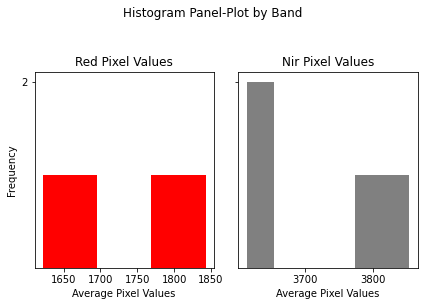

In [25]:
### Rachael - Create RGB Histograms (Pandas and Matplot) ###

# Reads in our file
deforestation_data = pd.read_csv('final_data.csv')

# red_min = deforestation_data.loc[deforestation_data['average_red'].idxmin()]
# red_max = deforestation_data.loc[deforestation_data['average_red'].idxmax()]
# nir_min = deforestation_data.loc[deforestation_data['average_nir'].idxmin()]
# nir_max = deforestation_data.loc[deforestation_data['average_nir'].idxmax()]

red_min = deforestation_data['average_red'].min()
red_max = deforestation_data['average_red'].max()
nir_min = deforestation_data['average_nir'].min()
nir_max = deforestation_data['average_nir'].max()

print("Red min: {}, Red max: {}, NIR min: {}, NIR max: {}".format(red_min, red_max, nir_min, nir_max))

# Separates our bands into rgb and nir arrays of values
red = deforestation_data['average_red']
nir = deforestation_data['average_nir']

# The number of histogram bins
bin_number = 6

# Create just a figure and only one subplot
fig, (ax1) = plt.subplots(1,2, sharey=True)

# Sets the number of ticks for the y-axis
plt.yticks([2, 4])

# Sets default background color (outside the plot area) to white
# *Keep this* otherwise it will default to grey and is hard to read
fig.patch.set_facecolor('white')

# Sets the colors and bin count of each plot
ax1[0].hist(red, color='red', bins=bin_number, range=[red_min, red_max]) #, range=[10, 60]
ax1[1].hist(nir, color='gray', bins=bin_number, range=[nir_min, nir_max]) #, range=[1600, 3800]

# States the title and axis labels for the plots
ax1[0].set_title('Red Pixel Values')
ax1[1].set_title('Nir Pixel Values')
ax1[0].set_ylabel('Frequency')
ax1[0].set_xlabel('Average Pixel Values')
ax1[1].set_xlabel('Average Pixel Values')

# Adds an overall title to the plot. The y argument moves the 
# title higher, so we don't have overlapping text.
plt.suptitle('Histogram Panel-Plot by Band', y=1.05)  

# This makes sure we have sufficient space between our plots
fig.tight_layout()

# Export the final plot into a .png file with padding!
fig.savefig(r"{}\histograms.png".format(home_directory), dpi=200, bbox_inches='tight', pad_inches=0.7)

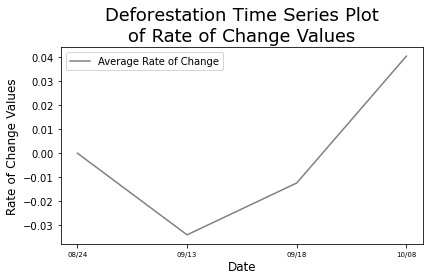

In [31]:
### Rachael - Create Time Series Histograms for % Average Pixel Values and Weekly Temperatures ###

# Sorts data by ascending date (September to December)
deforestation_data_sorted = deforestation_data.sort_values(by='date')

# Example
data = deforestation_data.set_index('date')

# Begin creating the RGB Time Series Plot
# Create RGB subplot and unpack the output array
fig, ax = plt.subplots()

# Sets default background color (outside the plot area) to white
# *Keep this* otherwise it will default to grey and is hard to read
fig.patch.set_facecolor('white')

# Add the line data we want to plot, with labels and bespoke markers
plt.plot(data["average_nir"], label='NIR', color='gray', marker='o')
plt.plot(data["average_red"], label='Red', color='red', marker='x')
plt.legend()

# Add the axes labels and limits
plt.xlabel("Date", fontname="Verdana", fontsize=12)
plt.ylabel("Average Pixel Values", fontname="Verdana", fontsize=12)

# Add the main plot title
plt.title("Deforestation Time Series Plot\nof Red and NIR Values", fontname="Verdana", fontsize=18)

#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=7)
# This makes sure we have sufficient space between our plots
fig.tight_layout()

# Now export the final plot!
fig.savefig(r"{}\red_nir_time_series.png".format(home_directory), dpi=200, 
            bbox_inches='tight', pad_inches=0.7)


# Begin creating the NIR Time Series Plot
ax.clear()

# Add the line data we want to plot, with labels and bespoke markers
plt.plot(data["ndvi"], label='NDVI', color='Green')
plt.legend()

# Add the axes labels and limits
plt.xlabel("Date", fontname="Verdana", fontsize=12)
plt.ylabel("NDVI Values", fontname="Verdana", fontsize=12)

# Add the main plot title
plt.title("Deforestation Time Series Plot\nof NDVI Values", fontname="Verdana", fontsize=18)

# Now export the final plot!
fig.savefig(r"{}\ndvi_time_series.png".format(home_directory), 
            dpi=200, bbox_inches='tight', pad_inches=0.7)

# Begin creating the Average Rate of Change Time Series Plot
ax.clear()

# Add the line data we want to plot, with labels and bespoke markers
plt.plot(data["average_roc"], label='Average Rate of Change', color='Gray')
plt.legend()

# Add the axes labels and limits
plt.xlabel("Date", fontname="Verdana", fontsize=12)
plt.ylabel("Rate of Change Values", fontname="Verdana", fontsize=12)

# Add the main plot title
plt.title("Deforestation Time Series Plot\nof Rate of Change Values", fontname="Verdana", fontsize=18)

# Now export the final plot!
fig.savefig(r"{}\roc_time_series.png".format(home_directory), 
            dpi=200, bbox_inches='tight', pad_inches=0.7)

In [33]:
### Creating GIFs with the images in the time-series ###

def create_gif(file_path):
    images = []

    # Example
    for filename in filenames:

        current_directory = os.getcwd()

        path =  os.path.join(current_directory, file_path, filename)

        #print(path) uncomment if you want to check if the path is correct

        images.append(imageio.imread(path)) # append our paths to images

    # Give the image list to imageio
    gif_filename = os.path.join('my_gif.gif')
    imageio.mimsave(gif_filename, images, duration=1)
    
    return

tci_file_path = 'Selection/TCI'
filenames = os.listdir(tci_file_path) #images is our chosen directory
create_gif(tci_file_path)

C:\Users\racha\AppData\Local\Temp\ipykernel_17244\3941141408.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path)) # append our paths to images
